In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report 
import joblib
import shap
import matplotlib.pyplot as plt


In [10]:
train_data = pd.read_csv('../data/train_data.csv')
test_data = pd.read_csv('../data/test_data.csv')


In [13]:
X_train, y_train = train_data.drop(columns=['treatment']), train_data['treatment']
X_test, y_test = test_data.drop(columns=['treatment']), test_data['treatment']

In [14]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_dict)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.6693227091633466, 1: 336.0,
                                     2: 0.6653465346534654},
                       random_state=42)

In [16]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=class_weights_dict[1], random_state=42)
xgb_model.fit(X_train, y_train)


c:\Users\INDIA\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)  

    print(f"\n{model_name} Performance:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


    if len(np.unique(y_test)) == y_prob.shape[1]:
        print("ROC-AUC:", roc_auc_score(pd.get_dummies(y_test), y_prob, average="weighted", multi_class="ovr"))

In [18]:
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       120
         2.0       0.82      0.82      0.82       132

    accuracy                           0.81       252
   macro avg       0.81      0.81      0.81       252
weighted avg       0.81      0.81      0.81       252

Accuracy: 0.8134920634920635
Precision: 0.8135824388426747
Recall: 0.8134920634920635
F1 Score: 0.8135244315923678

XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       120
         2.0       0.84      0.86      0.85       132

    accuracy                           0.84       252
   macro avg       0.84      0.84      0.84       252
weighted avg       0.84      0.84      0.84       252

Accuracy: 0.8373015873015873
Precision: 0.8373083706417038
Recall: 0.8373015873015873
F1 Score: 0.8371858865387525


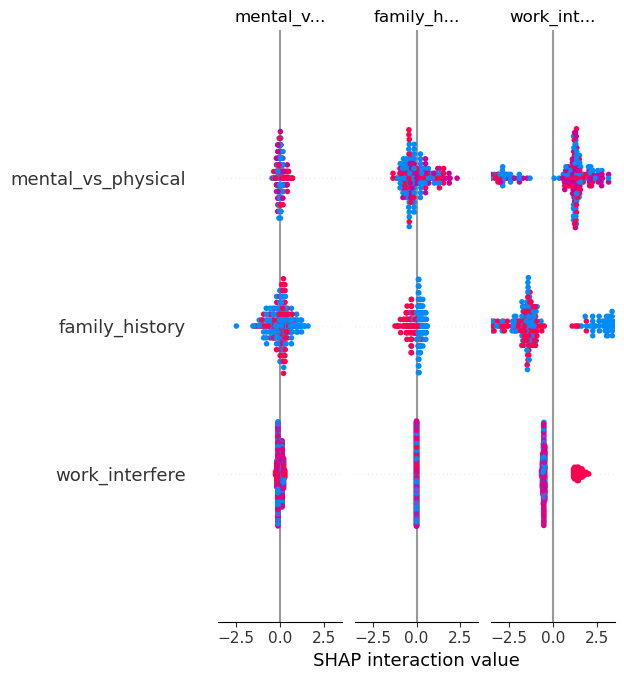

In [21]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [23]:
joblib.dump(xgb_model, "../models/mental_health_model.pkl")
print("Model saved successfully!")

Model saved successfully!
